In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import os

In [2]:
import os
import numpy as np
import pyedflib
import pywt
from sklearn.model_selection import train_test_split

def wavelet_transform(data, wavelet='db4', level=4):
    """
    Apply Wavelet Transform to EEG data.
    
    Parameters:
        data (numpy.ndarray): EEG data with shape (N, C), where N is the number of samples and C is the number of channels.
        wavelet (str): The type of wavelet to use (default: 'db4').
        level (int): The level of decomposition for the wavelet transform.

    Returns:
        numpy.ndarray: Transformed data with features extracted from wavelet coefficients.

        How WT is Applied to EEG in the Above Situation


Decomposition:

The EEG signal is decomposed into multiple levels (e.g., level=4) using a mother wavelet (e.g., db4, a Daubechies wavelet).
At each level, the signal is split into:
Approximation coefficients: Represent low-frequency trends.
Detail coefficients: Represent high-frequency details.
Feature Extraction:

For each EEG segment (160 samples per segment), WT computes coefficients that summarize frequency and time-domain characteristics.
These coefficients are reshaped into a feature matrix of size 186 × 64 (in your case) for machine learning models.
Improves Signal Representation:

WT allows the model to analyze EEG data at multiple resolutions, making it easier to distinguish between brain states or subjects.
Machine Learning Utility:

The extracted WT features are more informative and compact than raw EEG signals, improving classification and identification performance.

    """
    features = []
    for i in range(data.shape[1]):  # Loop through channels
        coeffs = pywt.wavedec(data[:, i], wavelet, level=level)
        # Concatenate coefficients from all levels
        features.append(np.concatenate(coeffs))
    return np.array(features).T

def _read_py_function(filename, num_channels=64):
    """
    Read EEG data from an EDF file and preprocess it.
    
    Parameters:
        filename (str): Path to the EDF file.
        num_channels (int): Number of channels to read (default: 64).

    Returns:
        tuple: Preprocessed EEG data and labels, or (None, None) if an error occurs.
    """
    try:
        # Open the EDF file
        f = pyedflib.EdfReader(filename)
        n_channels = f.signals_in_file
        print(f"File: {filename}, Total channels in file: {n_channels}")
        
        if num_channels > n_channels:
            raise ValueError(f"The file contains only {n_channels} channels, but {num_channels} were requested.")
        
        # Initialize eeg_data to store only the first `num_channels`
        eeg_data = np.zeros((num_channels, f.getNSamples()[0]), dtype=np.float32)
        for i in range(num_channels):
            eeg_data[i, :] = f.readSignal(i)
        
        n_samples = f.getNSamples()[0]
        reminder = int(n_samples % 160)
        print(f"Original n_samples: {n_samples}, Reminder: {reminder}")
        
        n_samples -= reminder
        seconds = int(n_samples / 160)
        
        # Extract person_id from the filename
        path = filename.split("\\")
        person_id = int(path[-1].partition("S")[2].partition("R")[0])
        label = np.zeros(10, dtype=bool)
        label[person_id - 1] = 1
        labels = np.tile(label, (seconds, 1))
        
        # Normalize data
        for i in range(num_channels):
            channel_data = eeg_data[i, :]
            mean_i = np.mean(channel_data)
            std_i = np.std(channel_data)
            if std_i != 0:
                eeg_data[i, :] = (channel_data - mean_i) / std_i
        
        eeg_data = eeg_data.T
        if reminder > 0:
            eeg_data = eeg_data[:-reminder, :]
        
        # Segment data into intervals
        intervals = np.linspace(0, n_samples, num=seconds, endpoint=False, dtype=int)
        eeg_data = np.split(eeg_data, intervals)
        del eeg_data[0]
        eeg_data = np.array(eeg_data)

        # Apply Wavelet Transform
        eeg_data = np.array([wavelet_transform(segment) for segment in eeg_data])
        print(f"Processed data shape after Wavelet Transform: {eeg_data.shape}, Labels shape: {labels.shape}")

        return eeg_data, labels

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None, None

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_eeg_data_with_pyedflib(data_path, max_subjects=10):
    # Initialize the global variables
    global subject_data, all_train_data, all_train_labels, all_test_data, all_test_labels
    global train_data, val_data, train_labels, val_labels

    # Initialize the variables before using them
    subject_data = {}
    all_train_data = []
    all_train_labels = []
    all_test_data = []
    all_test_labels = []

    subject_count = 0  # Counter to track the number of subjects processed

    for subject_dir in os.listdir(data_path):
        subject_path = os.path.join(data_path, subject_dir)
        if os.path.isdir(subject_path):
            print(f"Processing subject: {subject_dir}")
            subject_data[subject_dir] = {}
            for recording_file in os.listdir(subject_path):
                recording_path = os.path.join(subject_path, recording_file)
                if recording_file.endswith('.edf'):
                    recording_id = os.path.splitext(recording_file)[0]
                    print(f"Loading recording: {recording_file}")

                    try:
                        #eeg_data, labels = _read_py_function(recording_path)
                        eeg_data, labels = _read_py_function(recording_path)

                        print(f"Data shape after processing: {eeg_data.shape}")
                        print(f"Labels shape: {labels.shape}")

                        train_data, test_data, train_labels, test_labels = train_test_split(
                            eeg_data, labels, test_size=0.1, random_state=42
                        )
                        
                        all_train_data.append(train_data)
                        all_train_labels.append(train_labels)
                        all_test_data.append(test_data)
                        all_test_labels.append(test_labels)

                    except Exception as e:
                        print(f"Error loading {recording_file}: {e}")

            subject_count += 1  # Increment the subject counter

            # Stop processing once the desired number of subjects is reached
            if subject_count >= max_subjects:
                print(f"Processed {max_subjects} subjects. Stopping further processing.")
                break

    print(f"Train data list length: {len(all_train_data)}")
    print(f"Train labels list length: {len(all_train_labels)}")
    print(f"Test data list length: {len(all_test_data)}")
    print(f"Test labels list length: {len(all_test_labels)}")

    if all_train_data and all_train_labels:
        all_train_data = np.concatenate(all_train_data, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
    else:
        print("No training data loaded.")
        return None, None, None, None, None, None

    if all_test_data and all_test_labels:
        all_test_data = np.concatenate(all_test_data, axis=0)
        all_test_labels = np.concatenate(all_test_labels, axis=0)
    else:
        print("No test data loaded.")
        return None, None, None, None, None, None

    if len(all_train_data) == 0 or len(all_train_labels) == 0:
        print("No data available for splitting into training and validation sets.")
        return None, None, None, None, None, None

    # Split train data further into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(
        all_train_data, all_train_labels, test_size=0.25, random_state=42
    )

    return train_data, train_labels, val_data, val_labels, all_test_data, all_test_labels


In [4]:
data_path = r"C:/Users/akushwaha2024/Desktop/EEG_PROJECT/eeg-motor-movementimagery-dataset-1.0.0/files"
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_eeg_data_with_pyedflib(data_path)
# Access global variables directly if needed
print(f"Train data shape: {train_data.shape if train_data is not None else 'None'}")
print(f"Validation data shape: {val_data.shape if val_data is not None else 'None'}")
print(f"Test data shape: {test_data.shape if test_data is not None else 'None'}")

Processing subject: S001
Loading recording: S001R01.edf
File: C:/Users/akushwaha2024/Desktop/EEG_PROJECT/eeg-motor-movementimagery-dataset-1.0.0/files\S001\S001R01.edf, Total channels in file: 64
Original n_samples: 9760, Reminder: 0
Processed data shape after Wavelet Transform: (61, 186, 64), Labels shape: (61, 10)
Data shape after processing: (61, 186, 64)
Labels shape: (61, 10)
Loading recording: S001R02.edf
File: C:/Users/akushwaha2024/Desktop/EEG_PROJECT/eeg-motor-movementimagery-dataset-1.0.0/files\S001\S001R02.edf, Total channels in file: 64
Original n_samples: 9760, Reminder: 0
Processed data shape after Wavelet Transform: (61, 186, 64), Labels shape: (61, 10)
Data shape after processing: (61, 186, 64)
Labels shape: (61, 10)
Loading recording: S001R03.edf
File: C:/Users/akushwaha2024/Desktop/EEG_PROJECT/eeg-motor-movementimagery-dataset-1.0.0/files\S001\S001R03.edf, Total channels in file: 64
Original n_samples: 20000, Reminder: 0
Processed data shape after Wavelet Transform: (

In [5]:
import tensorflow as tf

def eeg_biometric_identification_model(input_shape, n_classes, lstm_size=192, keep_prob=0.5):
    inputs = tf.keras.Input(shape=input_shape)

    # 1D Convolutional Layers
    conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu')(inputs)
    conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='same', activation='relu')(conv1)
    conv3 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='same', activation='relu')(conv2)
    conv4 = tf.keras.layers.Conv1D(filters=1024, kernel_size=2, strides=1, padding='same', activation='relu')(conv3)

    # Flatten the convolution output before feeding into fully connected layers
    flatten = tf.keras.layers.Flatten()(conv4)

    # Fully connected layer with 192 neurons and dropout
    fc1 = tf.keras.layers.Dense(units=192, activation='relu')(flatten)
    dropout_fc1 = tf.keras.layers.Dropout(rate=1 - keep_prob)(fc1)

    # Reshape to (batch_size, timesteps=1, features=192) for LSTM input
    lstm_input = tf.keras.layers.Reshape((1, 192))(dropout_fc1)  

    # Add LSTM layers
    lstm_out = tf.keras.layers.LSTM(units=lstm_size, return_sequences=True)(lstm_input)  # First LSTM layer
    lstm_out = tf.keras.layers.LSTM(units=lstm_size, return_sequences=False)(lstm_out)  # Second LSTM layer

    # Fully connected layers after LSTM
    fc2 = tf.keras.layers.Dense(units=192, activation='relu')(lstm_out)
    fc3 = tf.keras.layers.Dense(units=192, activation='relu')(fc2)

    # Output layer (Softmax for classification)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(fc3)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

# Example usage
input_shape = (186, 64)  # 160 samples, 64 channels (1-second EEG recording)
n_classes = 10  # Number of subjects
keep_prob = 0.5  # Dropout rate

model = eeg_biometric_identification_model(input_shape, n_classes, lstm_size=192, keep_prob=keep_prob)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 186, 64)]         0         
                                                                 
 conv1d (Conv1D)             (None, 186, 128)          16512     
                                                                 
 conv1d_1 (Conv1D)           (None, 186, 256)          65792     
                                                                 
 conv1d_2 (Conv1D)           (None, 186, 512)          262656    
                                                                 
 conv1d_3 (Conv1D)           (None, 186, 1024)         1049600   
                                                                 
 flatten (Flatten)           (None, 190464)            0         
                                                                 
 dense (Dense)               (None, 192)               365692

In [6]:
# checkpoint_path = "cp-{epoch:04d}.weights.h5"  # Save checkpoints in the current directory
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# # Save the initial weights before training (optional)
# model.save_weights(checkpoint_path.format(epoch=0))

# # Training the model
# with tf.device('/GPU:0'):  # Ensure training uses the GPU
#     history = model.fit(train_data,train_labels, epochs=20, 
#                         validation_data=(val_data, val_labels), 
#                         batch_size=80,  
#                         callbacks=[cp_callback])
    
checkpoint_path = "C:/Users/akushwaha2024/Desktop/EEG_PROJECT/best_model/CNN_LSTM_64.weights.h5"  # Save the best model in the current directory
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor='val_loss',  # Monitor validation loss
                                                 mode='min',  # Save the model with the lowest validation loss
                                                 verbose=1)

# Training the model
with tf.device('/GPU:0'):  # Ensure training uses the GPU
    history = model.fit(train_data, train_labels, 
                        epochs=20, 
                        validation_data=(val_data, val_labels), 
                        batch_size=80,  
                        callbacks=[cp_callback])

Epoch 1/20
135/135 [==============================] - ETA: 0s - loss: 1.9060 - accuracy: 0.3095
Epoch 1: val_loss improved from inf to 1.12661, saving model to C:/Users/akushwaha2024/Desktop/EEG_PROJECT/best_model\CNN_LSTM_64.weights.h5
135/135 [==============================] - 89s 630ms/step - loss: 1.9060 - accuracy: 0.3095 - val_loss: 1.1266 - val_accuracy: 0.5811
Epoch 2/20
135/135 [==============================] - ETA: 0s - loss: 0.9452 - accuracy: 0.6405
Epoch 2: val_loss improved from 1.12661 to 0.57333, saving model to C:/Users/akushwaha2024/Desktop/EEG_PROJECT/best_model\CNN_LSTM_64.weights.h5
135/135 [==============================] - 83s 615ms/step - loss: 0.9452 - accuracy: 0.6405 - val_loss: 0.5733 - val_accuracy: 0.7991
Epoch 3/20
135/135 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.8742
Epoch 3: val_loss improved from 0.57333 to 0.11313, saving model to C:/Users/akushwaha2024/Desktop/EEG_PROJECT/best_model\CNN_LSTM_64.weights.h5
135/135 [====

In [7]:

# Save the training history as a numpy file
np.save("history_CNN_LSTM_64.npy", history.history)

# Load the training history
history = np.load("history_CNN_LSTM_64.npy", allow_pickle=True).item()

# Ensure history is a dictionary
if type(history) is not dict:
    history = history.history

# Find the epoch with the highest validation accuracy
max_value = max(history['val_accuracy'])
print(f"Max Validation Accuracy: {max_value}")

max_index = history['val_accuracy'].index(max_value)
print(f"Best Epoch Index: {max_index}")
print(f"Corresponding Training Accuracy: {history['accuracy'][max_index]}")

# Load the best checkpoint based on validation accuracy
model.load_weights(checkpoint_path)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x=test_data, y=test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Max Validation Accuracy: 0.9980490803718567
Best Epoch Index: 8
Corresponding Training Accuracy: 0.9952619671821594
54/54 [==============================] - 10s 182ms/step - loss: 0.0101 - accuracy: 0.9965
Test Loss: 0.010117817670106888
Test Accuracy: 0.99647057056427


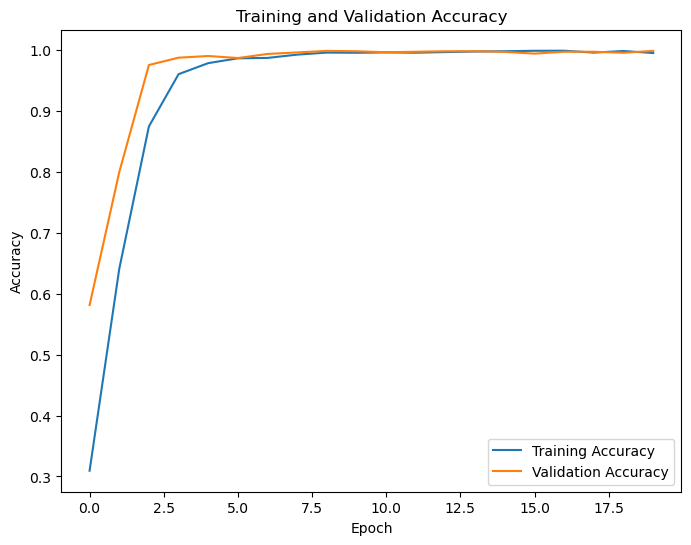

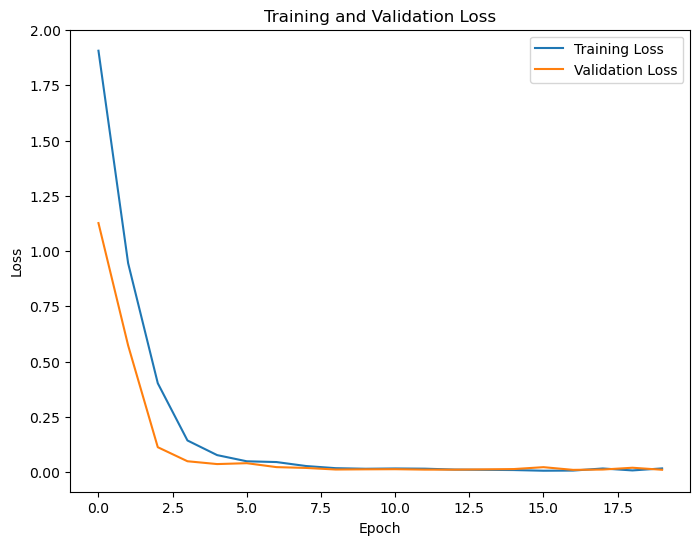

In [8]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.savefig("accuracy_plot.png")  # Save the accuracy plot
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig("loss_plot.png")  # Save the loss plot
plt.show()

54/54 [==============================] - 21s 184ms/step
Confusion Matrix:
[[170   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0]
 [  1   0 169   0   0   0   0   0   0   0]
 [  0   0   0 169   0   0   0   1   0   0]
 [  0   0   0   0 170   0   0   0   0   0]
 [  0   1   0   0   0 169   0   0   0   0]
 [  0   0   0   0   0   0 170   0   0   0]
 [  0   1   0   0   0   0   0 169   0   0]
 [  0   0   0   1   0   0   0   0 169   0]
 [  0   0   0   0   0   0   0   0   0 170]]


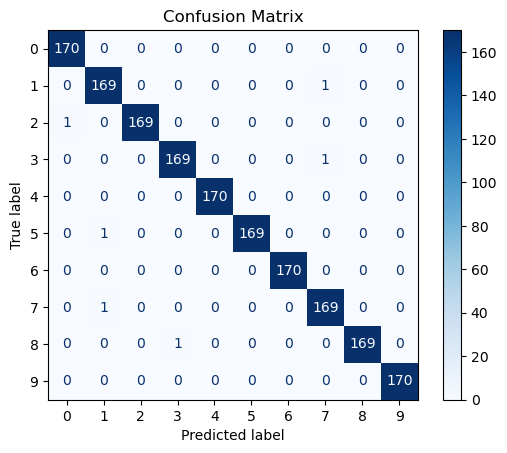

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the predictions from the model on the test data
predictions = model.predict(test_data)

# Convert the predicted probabilities into class predictions (argmax over class probabilities)
predicted_classes = np.argmax(predictions, axis=1)

# Convert the one-hot encoded test labels back to their original class labels
true_classes = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()